# Demo: Additive Gaussian processes under monotonicity constraints in 2D

In this notebook, we propose a demo example of the implementation of an additive Gaussian process (GP) under monotonicity constraints. The model is constructed via the MaxMod algorithm proposed in [1]

[1] A. F. López-Lopera, F. Bachoc and O. Roustant (2022). *High-dimensional additive Gaussian processes under monotonicity constraints*, in NeurIPS. URL: https://arxiv.org/abs/2205.08528.

In [1]:
# loading useful libraries
library("lineqGPR")
require("DiceDesign")
library("plot3D")
library("viridis")

rm(list=ls())
options(warn=-1)

Le chargement a nécessité le package : broom

Le chargement a nécessité le package : nloptr

Le chargement a nécessité le package : purrr

Le chargement a nécessité le package : DiceDesign

Le chargement a nécessité le package : viridisLite



In [2]:
# Synthetic data: monotonic function
targetFun <- function(x) return(atan(5*x[,2])  + 0.5*x[,1])

In [3]:
d <- 2 # number of active input variables

# building DoE in dimension D via Latin hypercube sampling (LHS)
xdesign <- lhsDesign(2e1*d, d, seed = 7)$design
ydesignNoNoise <- targetFun(xdesign)
varNoise <- max(range(ydesignNoNoise))*0.01
ydesign <- ydesignNoNoise

# building a DoE for assessing the model
ntest <- 50
xtest <- matrix(seq(0, 1, length = ntest))
xtest <- as.matrix(expand.grid(xtest, xtest))
ytest <- targetFun(xtest)

In [4]:
# initializing a 1D GP model with only two knots 
model <-  create(class = 'lineqAGP',
                 x = xdesign, y = ydesign,
                 constrType = rep("monotonicity", d), m = 2)
for (k in 1:d) 
  model$kernParam[[k]]$par <- c(1, 2)
model$localParam$sampler <- "HMC"
model$nugget <- 1e-7
model$varnoise <- 0.01*sd(ydesign)^2

In [5]:
# updating the model according to the MaxMod algorithm
max_iter <- 10
tol <- 1e-4
model <- AdditiveMaxMod(model,
                        xtest,
                        tol = tol,
                        max_iter = max_iter,
                        reward_new_knot = 1e-9,
                        reward_new_dim = 1e-12,
                        print_iter = TRUE,
                        nClusters = 1,
                        save_history = TRUE)

message("\nNumber of active dimensions: ", d)
message("Number of actived dimensions via MaxMod: ", model$d, "\n")
idxAdd <- unique(model$MaxMod$optDecision)

                    dim 1  dim 2
MaxMod criterion 1.687768 1.7829
knot's position       NaN    NaN
decision         0.000000 1.0000


Iter 1 - dimension 2 added as d = 1 (Relative MaxMod criterion = Inf)



                      dim 1      dim 2
MaxMod criterion 0.01280766 0.01380527
knot's position         NaN 0.44210100
decision         0.00000000 1.00000000


Iter 2 - New knot added: d = 1 (Relative MaxMod criterion = 0.0077431507125538)



                      dim 1        dim 2
MaxMod criterion 0.01794539 0.0008991189
knot's position         NaN 0.6936450530
decision         1.00000000 0.0000000000


Iter 3 - dimension 1 added as d = 2 (Relative MaxMod criterion = 0.0101675900268433)



                        dim 1       dim 2
MaxMod criterion 0.0005742976 0.003592186
knot's position  0.4658984589 0.206021096
decision         0.0000000000 1.000000000


Iter 4 - New knot added: d = 1 (Relative MaxMod criterion = 0.00200648521550084)



                        dim 1       dim 2
MaxMod criterion 4.997841e-05 0.000201412
knot's position  3.653086e-01 0.332055159
decision         0.000000e+00 1.000000000


Iter 5 - New knot added: d = 1 (Relative MaxMod criterion = 0.000113150949749103)



                        dim 1        dim 2
MaxMod criterion 3.344924e-05 0.0001746237
knot's position  2.805204e-01 0.6661667257
decision         0.000000e+00 1.0000000000


Iter 6 - New knot added: d = 1 (Relative MaxMod criterion = 9.81990184862386e-05)

The sequential algorithm converged


Number of active dimensions: 2

Number of actived dimensions via MaxMod: 2




In [6]:
# evaluating the model using an equispaced grid of points
pred <- predict(model, xtest)
model$localParam$sampler <- "HMC"
sim.model <- simulate(model, nsim = 1e3, xtest = xtest)

u <- expand.grid(model$ulist[[1]], model$ulist[[2]])
pred_Knots <- predict(model, as.matrix(u))
PhiAllknots.test <- cbind(pred_Knots$Phi.test[[1]][rep(1:model$localParam$m[1], times = model$localParam$m[2]), ],
                          pred_Knots$Phi.test[[2]][rep(1:model$localParam$m[2], each = model$localParam$m[1]), ])

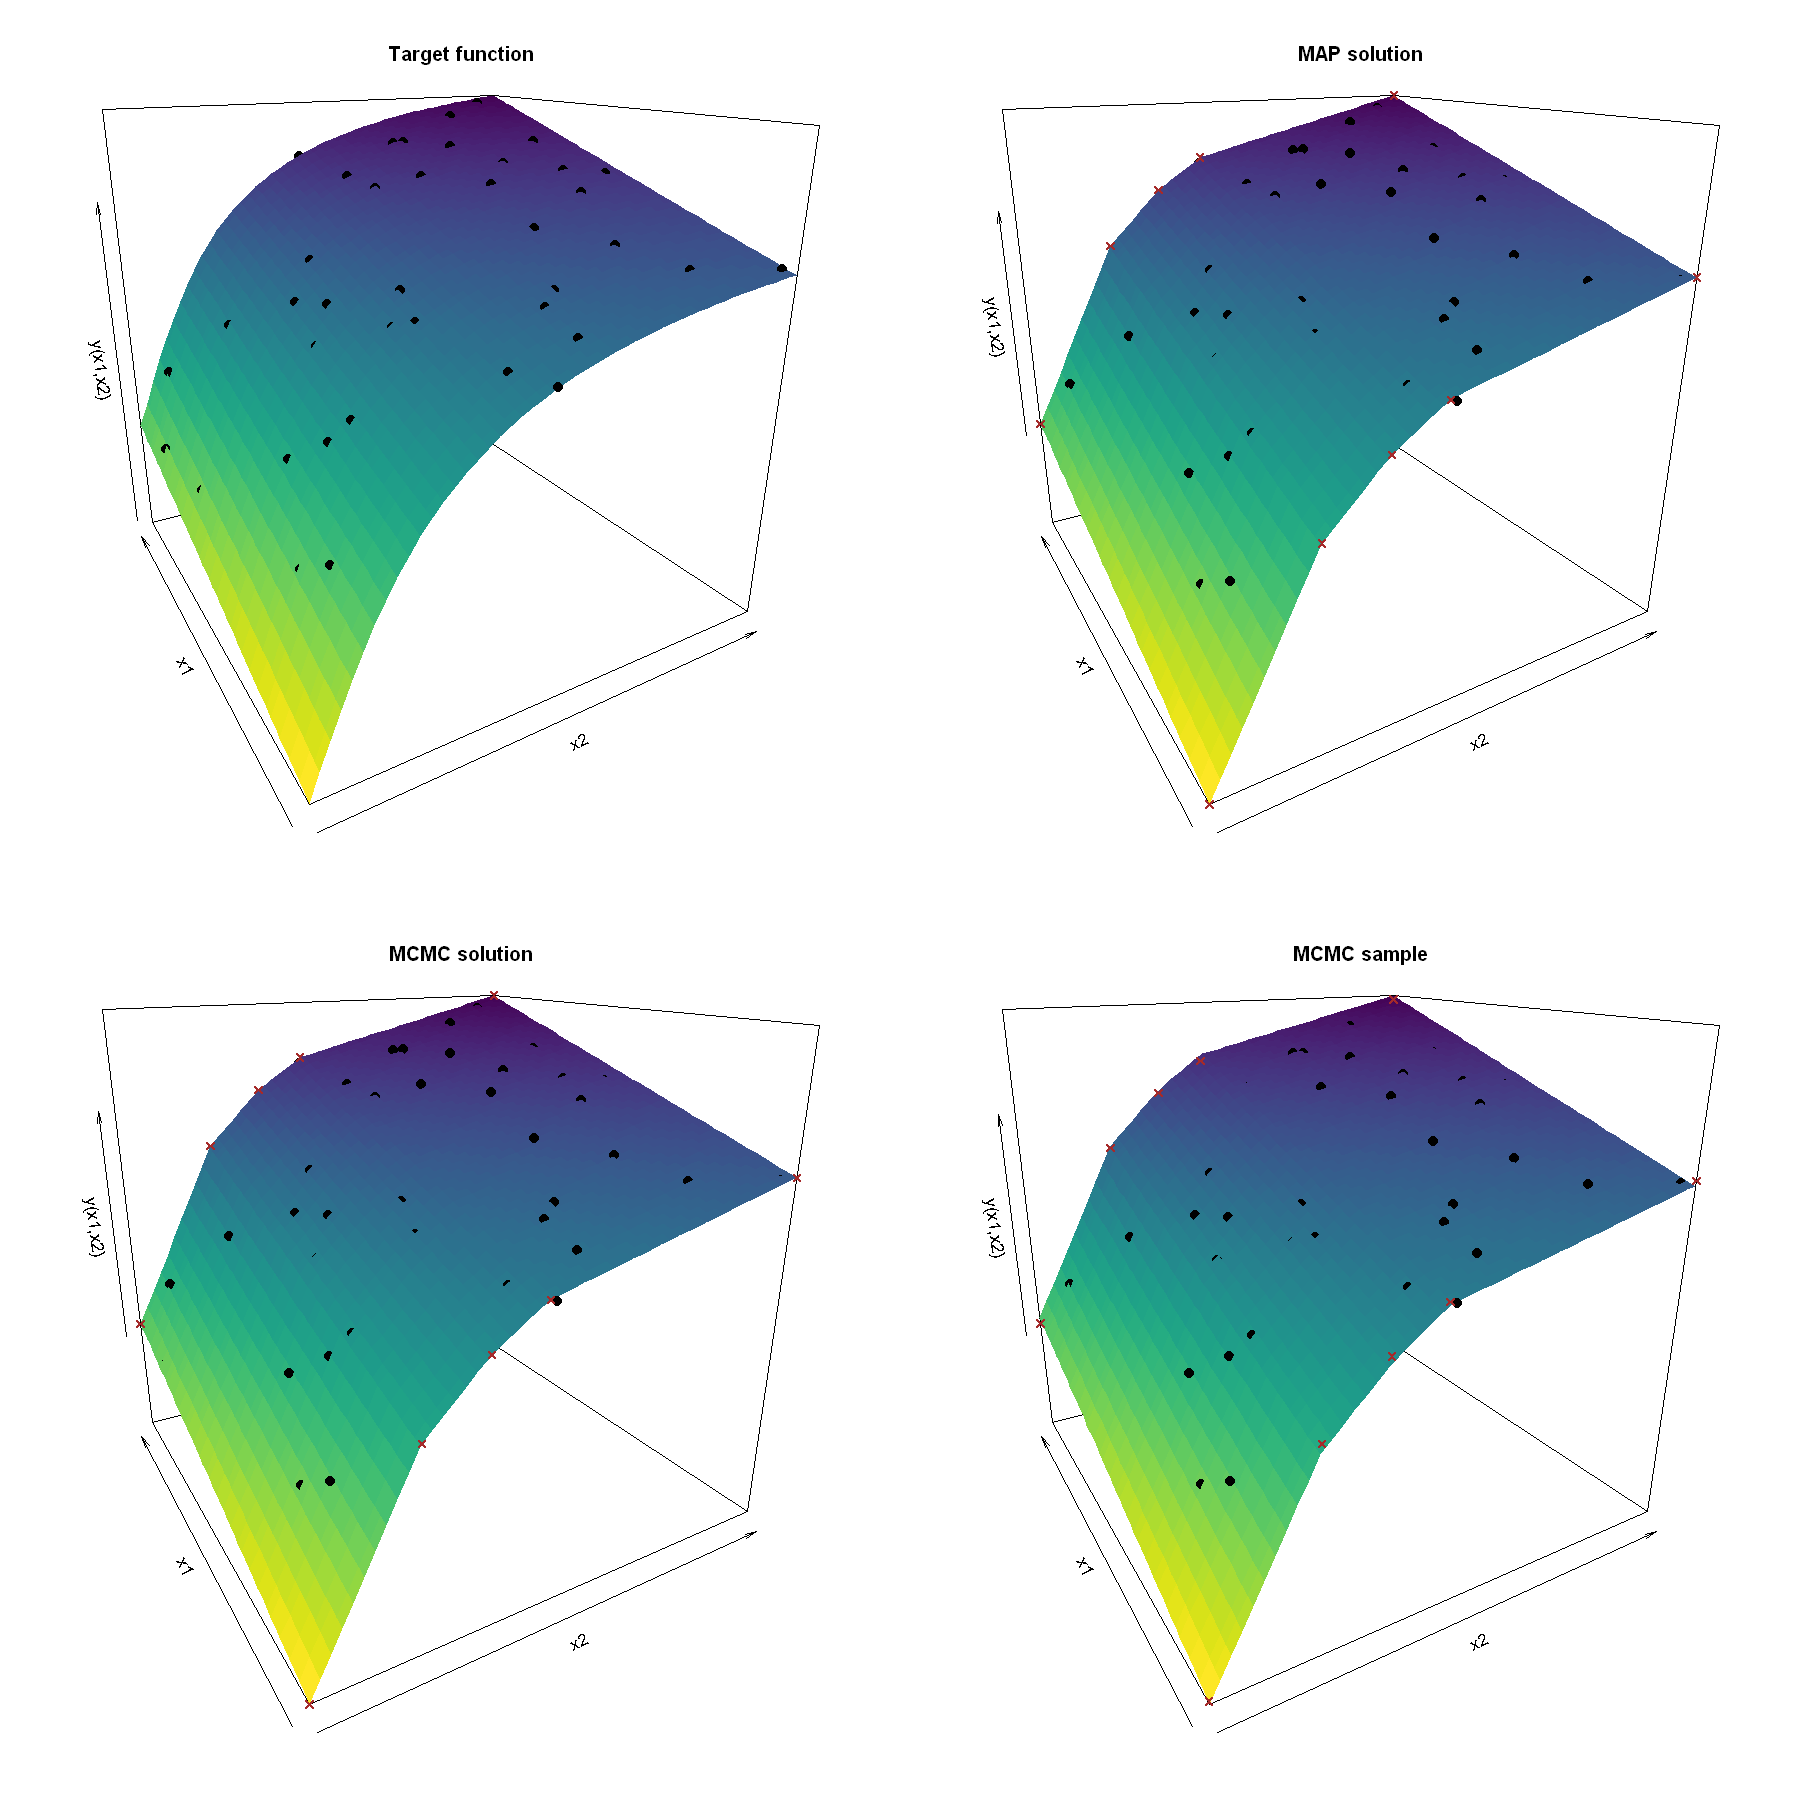

In [7]:
# plotting the MAP estimate
colormap <- rev(viridis(1e2))
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow = c(2,2), mar=c(1.5,1.5,1.5,1))
p <- persp3D(x = unique(xtest[, idxAdd[1]]), y = unique(xtest[, idxAdd[2]]),
             z = matrix(targetFun(xtest[, idxAdd]), ntest, ntest),
             xlab = paste("x", idxAdd[1], sep = ""), ylab = paste("x", idxAdd[2], sep = ""), zlab = "y(x1,x2)",
             main = "Target function", phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(xdesign[,idxAdd[1]], xdesign[,idxAdd[2]], ydesignNoNoise, pch = 20, cex = 2,  col = "black", add = TRUE)

p <- persp3D(x = unique(xtest[, 1]), y = unique(xtest[, 2]),
             z = matrix(pred$PhiAll.test %*% pred$xiAll.map, ntest, ntest),
             xlab = paste("x", idxAdd[1], sep = ""), ylab = paste("x", idxAdd[2], sep = ""), zlab = "y(x1,x2)",
             main = "MAP solution", phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(xdesign[,idxAdd[1]], xdesign[,idxAdd[2]], ydesignNoNoise, pch = 20, cex = 2,  col = "black", add = TRUE)
points(trans3D(x = u[,1], y = u[,2], z = pred_Knots$PhiAll.test %*% pred_Knots$xiAll.map, pmat = p),
       col = 'brown', pch = 4, lwd = 2)

p <- persp3D(x = unique(xtest[, 1]), y = unique(xtest[, 2]),
             z = matrix(rowMeans(sim.model$PhiAll.test %*% sim.model$xiAll.sim), ntest, ntest),
             xlab = paste("x", idxAdd[1], sep = ""), ylab = paste("x", idxAdd[2], sep = ""), zlab = "y(x1,x2)",
             main = "MCMC solution", phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(xdesign[,idxAdd[1]], xdesign[,idxAdd[2]], ydesignNoNoise, pch = 20, cex = 2,  col = "black", add = TRUE)
points(trans3D(x = u[,1], y = u[,2], z = pred_Knots$PhiAll.test %*% pred_Knots$xiAll.map, pmat = p),
       col = 'brown', pch = 4, lwd = 2)

p <- persp3D(x = unique(xtest[, 1]), y = unique(xtest[, 2]),
             z = matrix(sim.model$PhiAll.test %*% sim.model$xiAll.sim[,1], ntest, ntest),
             xlab = paste("x", idxAdd[1], sep = ""), ylab = paste("x", idxAdd[2], sep = ""), zlab = "y(x1,x2)",
             main = "MCMC sample", phi = 20, theta = -30, col = colormap, colkey = FALSE)
points3D(xdesign[,idxAdd[1]], xdesign[,idxAdd[2]], ydesignNoNoise, pch = 20, cex = 2,  col = "black", add = TRUE)
points(trans3D(x = u[,1], y = u[,2], z = pred_Knots$PhiAll.test %*% pred_Knots$xiAll.map, pmat = p),
       col = 'brown', pch = 4, lwd = 2)
